In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.io import fits
import celerite
from celerite import terms
from scipy.optimize import minimize, curve_fit
import time

In [2]:
filename = 'tess2018206045859-s0001-0000000024292848-0120-s_lc.fits'
with fits.open(filename, mode='readonly') as hdulist:
    tess_bjd = hdulist[1].data['TIME']
    quality = hdulist[1].data['QUALITY']
    pdcsap_flux = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']

quality_cut = quality == 0
tess_bjd = tess_bjd[quality_cut]
pdcsap_flux = pdcsap_flux[quality_cut]
pdcsap_flux_error = pdcsap_flux_error[quality_cut]

18062


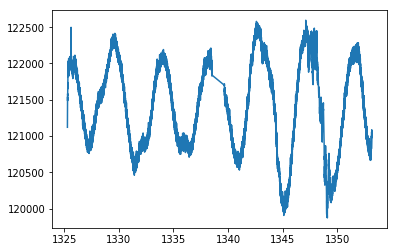

In [3]:
plt.plot(tess_bjd, pdcsap_flux)
print(len(tess_bjd))

In [4]:
def predictGP(x, y, yerr):
    start_time = time.time()
    # A non-periodic component
    Q = 1.0 / np.sqrt(2.0)
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-20, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                           bounds=bounds)
    kernel.freeze_parameter('log_Q')

    # A periodic component
    Q = 1.0
    w0 = 2*np.pi/10
    S0 = np.var(y) / (w0 * Q)
    kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                            bounds=bounds)

    # Now calculate the covariance matrix using the initial
    # kernel parameters
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(x, yerr)

    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    def grad_neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y)[1]

    bounds = gp.get_parameter_bounds()
    initial_params = gp.get_parameter_vector()

    gp.compute(x, yerr)
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method='L-BFGS-B', bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(soln.x)
    initial_params = soln.x
    mu, var = gp.predict(y, x, return_var=True)
    
    return mu, var, time.time() - start_time

In [12]:
# Time the GP regression using progressively more data points

red_fac = np.arange(0.1, 1.1, 0.1)
npts = []
elapsed_time = []
for fac in red_fac:
    npts_val = int(len(tess_bjd)*fac)
    x = tess_bjd[:npts_val]
    y = pdcsap_flux[:npts_val]/np.median(pdcsap_flux)
    yerr = pdcsap_flux_error[:npts_val]/np.median(pdcsap_flux)
    mu, var, time_val = predictGP(x, y, yerr)
    npts.append(npts_val)
    elapsed_time.append(time_val)

Text(0, 0.5, 'Elapsed Time (s)')

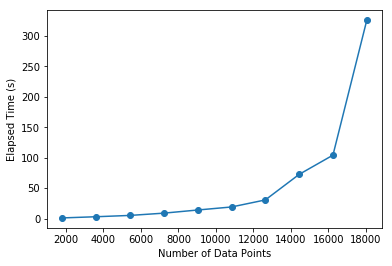

In [15]:
plt.plot(npts, elapsed_time, '-o')
plt.xlabel('Number of Data Points')
plt.ylabel('Elapsed Time (s)')

Text(0, 0.5, 'Normalized Flux')

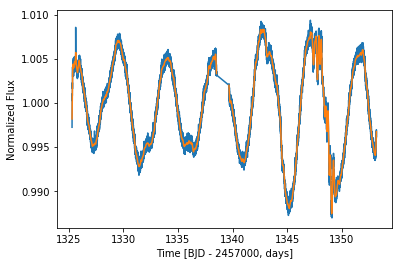

In [16]:
plt.plot(x, y)
plt.plot(x, mu)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Normalized Flux')